In [1]:
import torch  
import random
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import genpareto

In [2]:
# NOAA sea level rise predictions
#input 'scale_parameter_gammadstrb'
B= 0.5;

#input 'shape_parameter_gammadstrb'
A= np.zeros((3,100))
A[0,:]=np.arange(11.2,12.388,0.012);# intermediate low rise case
A[1,:]=np.arange(13,35,0.22);# intermediate high rise case
A[2,:]= np.arange(14.6,88.6,0.74);# high rise case

# generalized pareto    
power_l=0.9;
power_s= 0.8;  
eta=250;
k= -0.1;
theta= 14;

#parameters for cost definition
beta=14 ; #coefficient of residents' investment decision y_n, residents', contribution of 14M $/yearly, 1M $ taken as unit
alpha=300; # 300m $ is the coefficient for investment cost

In [72]:
class ActorCritic(nn.Module):
    def __init__(self, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_inputs=2 
        self.num_actions = 5
        self.critic_linear1 = nn.Linear(self.num_inputs, 12)
        self.critic_linear2 = nn.Linear(12, 120)
        self.critic_linear3 = nn.Linear(120, 12)        
        self.critic_linear4 = nn.Linear(12, 1)

        self.actor_linear1 = nn.Linear(self.num_inputs, 12)
        self.actor_linear2 = nn.Linear(12, 12)
        #self.actor_linear3 = nn.Linear(120, 12)
        self.actor_linear4 = nn.Linear(12, self.num_actions)
   
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        value = F.relu(self.critic_linear1(state))
        value = F.relu(self.critic_linear2(value))
        value = F.relu(self.critic_linear3(value))                
        value = self.critic_linear4(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.relu(self.actor_linear2(policy_dist))
        #policy_dist = F.relu(self.actor_linear3(policy_dist))                
        policy_dist = F.softmax(self.actor_linear4(policy_dist), dim=1)

        return value, policy_dist      

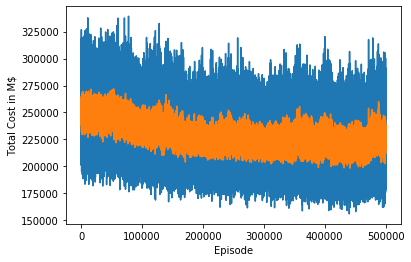

Total cost: 229316.54368877417, final cost: 225624.83243584784
Wall time: 9h 3min 24s


In [132]:
%%time
GAMMA = 0.99
a_g= 0.9; ## Government's cooperation index
a_r= 0.9; ## Residents' cooperation index
a=2; ## SLR scenarios; a=0,1, and 2, respectively for intermediate low, intermediate, and high sea level rise projections. 

s_norm=400,# normalozing s
l_norm=[580, 1190,2590];# normalozing s
q_end= [145500,215300,338700] ;# Qval for y=100, the limit of utility= reward/(1-gamma), calculated using s=[250,300,350], x=[600,750,900]
years = 100
episodes = 500000

actor_critic = ActorCritic()
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=3e-4)

all_rewards = []
entropy_term = 0
    
for episode in range(episodes):
	log_probs = []; # log probabilities of action
	values = np.zeros(years)
	rewards = np.zeros(years)


	l= np.zeros(101);
	s= np.zeros(101);
	l[0]=100; # initial relative sea level
	s[0]=50; # initial infrastructure state  
	r=0; # sea level rise each year
	q= np.zeros(101);  # yearly residents' decision score          
	sig= np.zeros(101);# yearly sigmoid input for residents' decision           
	res= np.zeros(101); # yearly residents' binary decision 
	x= np.zeros(100); #  yearly govenment's decision         
	z= np.zeros(100); # yearly cost from nature
	state= np.zeros((1,2));
	next_state= np.zeros((1,2));
	for y in range(years):
		state[0,0]= (l[y]-l[0])/l_norm[a];             
		state[0,1]= (s[y]-s[0])/s_norm;             

		value, policy_dist = actor_critic.forward(state)
		values[y] = value.detach().numpy()# converts tensor to array
		dist = policy_dist.detach().numpy() # converts tensor to array

		action =np.random.choice(5, p=np.squeeze(dist)) # random.randrange(5)
		x[y]= action;
		z[y]=genpareto.rvs(k, loc=theta, scale=eta* np.power(l[y],power_l)/np.power(s[y],power_s)); # genpareto, shape,k=-0.1,location,theta=0; scale,sigma                    
		q[y+1]=a_r*(q[y]+ action/4 * z[y]); ## dividing the action by 4 because action can be o~3
		sig[y+1]= 1/(1 + np.exp(-(q[y+1]-5)));
		res[y+1]= np.random.binomial(1, sig[y+1]);  

		r= np.random.gamma(A[a,y],B);                                         
		l[y+1]= l[y]+r;                
		s[y+1]= s[y]+action; 
		next_state[0,0]= (l[y+1]-l[0])/l_norm[a]; #  As the growth rate of shape parameter is fixed for any scenario,so {A[a,y]/2+A[a,6]/2-A[a,5]/2} simply means expected sea level rise for next year            
		next_state[0,1]= (s[y+1]-s[0])/s_norm;  
		rewards[y]=alpha*x[y]-beta*res[y]+z[y];
        
		log_prob = torch.log(policy_dist.squeeze(0)[action])
		entropy = -np.sum(np.mean(dist) * np.log(dist))
		log_probs.append(log_prob)
		entropy_term += entropy
		state = next_state
            
	Qval, transition = actor_critic.forward(next_state)
	Qval = Qval.detach().numpy()
	all_rewards.append(np.sum(rewards))
            
        # compute Q values
	Qvals = np.zeros(years)
#	Qvals = -q_end[a]* np.ones(years)
	for t in reversed(range(years)):
		Qval = -rewards[t] + GAMMA * Qval
		Qvals[t] = Qval
#		Qvals[t-1] = Qval
  
        #update actor critic
	values = torch.FloatTensor(values)
	Qvals = torch.FloatTensor(Qvals)
	log_probs = torch.stack(log_probs)
        
	advantage = Qvals - values
	actor_loss = (-log_probs * advantage).mean()
	critic_loss = 0.5 * advantage.pow(2).mean()
	ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

	ac_optimizer.zero_grad() #Sets gradients of all model parameters to zero, needs to be done before "ac_loss.backward()"
	ac_loss.backward()
	ac_optimizer.step()
    
    # Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in M$')
plt.show()

print("Total cost: {}, final cost: {}" .format(np.sum(all_rewards)/episodes,np.sum(all_rewards[(episodes-10000):episodes])/10000))

In [7]:
12-120-12-adam-Wall time: 10h 33min 10s  Total cost: 225548.2347839094, final cost: 217968.5676895316... without line-75-78
12-24-12-adam-Wall time: 10h 26min 3s  Total cost: 229238.48937840114, final cost: 215675.8434497693... without line-75-78
24-24-adam-Wall time: 8h 49min 22s  Total cost: 226882.83891258846, final cost: 215329.97553751039... without line-75-78
24-24-adam-Wall time: 8h 50min 20s  Total cost: 225607.34891411266, final cost: 222443.64749462958... with line-75-78

Total cost: 225607.34891411266, final cost: 222443.64749462958


episode: 0, Total Cost in M$: 229327.27511138478,val: 0.23396235704421997
episode: 50000, Total Cost in M$: 228940.2510959002,val: 0.23533686995506287
episode: 100000, Total Cost in M$: 232251.61557794976,val: 0.23688986897468567
episode: 150000, Total Cost in M$: 232725.4849572598,val: 0.23073595762252808
episode: 200000, Total Cost in M$: 253133.93214258464,val: 0.2334994524717331
episode: 250000, Total Cost in M$: 214679.82790354284,val: 0.22845736145973206
episode: 300000, Total Cost in M$: 221828.94098694267,val: 0.22880592942237854
episode: 350000, Total Cost in M$: 249825.16559746113,val: 0.2286432683467865
episode: 400000, Total Cost in M$: 211937.59169494617,val: 0.23486065864562988
episode: 450000, Total Cost in M$: 237740.5929754192,val: 0.22895407676696777
episode: 500000, Total Cost in M$: 244666.82683245433,val: 0.2306327223777771
episode: 550000, Total Cost in M$: 212645.7057477563,val: 0.22714319825172424
episode: 600000, Total Cost in M$: 237615.7943908565,val: 0.22614

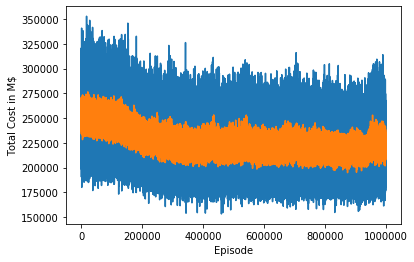

Wall time: 14h 59min 39s


In [16]:
%%time
GAMMA = 0.99
a_g= 0.9; ## Government's cooperation index
a_r= 0.9; ## Residents' cooperation index
a=2; ## SLR scenarios; a=0,1, and 2, respectively for intermediate low, intermediate, and high sea level rise projections. 

s_norm=400,# normalozing s
l_norm=[580, 1190,2590];# normalozing s
scene= ['low','inter','high']
years = 100
max_episodes = 1000000
hidden_size = 12

actor_critic = ActorCritic(hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=3e-4)

all_rewards = []
entropy_term = 0
    
for episode in range(max_episodes):
	log_probs = []; # log probabilities of action
	values = []
	rewards = []


	l= np.zeros(101);
	s= np.zeros(101);
	l[0]=100; # initial relative sea level
	s[0]=50; # initial infrastructure state  
	r=0; # sea level rise each year
	q= np.zeros(101);  # yearly residents' decision score          
	sig= np.zeros(101);# yearly sigmoid input for residents' decision           
	res= np.zeros(101); # yearly residents' binary decision 
	x= np.zeros(100); #  yearly govenment's decision         
	z= np.zeros(100); # yearly cost from nature
	state= np.zeros((1,2));
	next_state= np.zeros((1,2));
	for y in range(years):
		state[0,0]= (l[y]-l[0])/l_norm[a];             
		state[0,1]= (s[y]-s[0])/s_norm;             

		value, policy_dist = actor_critic.forward(state)
		value = value.detach().numpy()[0,0] # converts tensor to array
		dist = policy_dist.detach().numpy() # converts tensor to array

		action =np.random.choice(5, p=np.squeeze(dist)) # random.randrange(5)
		x[y]= action;
		z[y]=genpareto.rvs(k, loc=theta, scale=eta* np.power(l[y],power_l)/np.power(s[y],power_s)); # genpareto, shape,k=-0.1,location,theta=0; scale,sigma         
            
		log_prob = torch.log(policy_dist.squeeze(0)[action])
		entropy = -np.sum(np.mean(dist) * np.log(dist))
		q[y+1]=a_r*(q[y]+ action/4 * z[y]); ## dividing the action by 4 because action can be o~3
		sig[y+1]= 1/(1 + np.exp(-(q[y+1]-5)));
		res[y+1]= np.random.binomial(1, sig[y+1]);  

		r= np.random.gamma(A[a,y],B);                                         
		l[y+1]= l[y]+r;                
		s[y+1]= s[y]+action; 
		next_state[0,0]= (l[y+1]-l[0])/l_norm[a]; #  As the growth rate of shape parameter is fixed for any scenario,so {A[a,y]/2+A[a,6]/2-A[a,5]/2} simply means expected sea level rise for next year            
		next_state[0,1]= (s[y+1]-s[0])/s_norm;  
		reward=alpha*x[y]-beta*res[y]+z[y]; 
		rewards.append(reward)  

		values.append(value)
		log_probs.append(log_prob)
		entropy_term += entropy
		state = next_state
            
		if  y == years-1:
			Qval, transition = actor_critic.forward(next_state)
			Qval = Qval.detach().numpy()[0,0]
			all_rewards.append(np.sum(rewards))


			if episode % 50000== 0:                    
				sys.stdout.write("episode: {}, Total Cost in M$: {},val: {}\n"
                                 .format(episode, np.sum(rewards), value))
			break
        
        # compute Q values
	Qvals = np.zeros(years)
	for t in reversed(range(years)):
		Qval = -rewards[t] + GAMMA * Qval
		Qvals[t] = Qval
  
        #update actor critic
	values = torch.FloatTensor(values)
	Qvals = torch.FloatTensor(Qvals)
	log_probs = torch.stack(log_probs)
        
	advantage = Qvals - values
	actor_loss = (-log_probs * advantage).mean()
	critic_loss = 0.5 * advantage.pow(2).mean()
	ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

	ac_optimizer.zero_grad() #Sets gradients of all model parameters to zero, needs to be done before "ac_loss.backward()"
	ac_loss.backward()
	ac_optimizer.step()
    
    # Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in M$')
plt.show()

episode: 0, Total Cost in M$: 192678.56456638046,val: -0.10507838428020477
episode: 10000, Total Cost in M$: 202592.30691409056,val: -0.12074203044176102
episode: 20000, Total Cost in M$: 170392.84950038051,val: -0.10044921189546585
episode: 30000, Total Cost in M$: 158722.6498601774,val: -0.11318430304527283
episode: 40000, Total Cost in M$: 186750.1282870807,val: -0.0931740403175354
episode: 50000, Total Cost in M$: 167686.21230378986,val: -0.09192882478237152
episode: 60000, Total Cost in M$: 188573.43847380904,val: -0.10071267187595367
episode: 70000, Total Cost in M$: 194621.40972119055,val: -0.08115503191947937
episode: 80000, Total Cost in M$: 181252.965464022,val: -0.07927151024341583
episode: 90000, Total Cost in M$: 187998.9337043662,val: -0.0782431811094284
episode: 100000, Total Cost in M$: 181406.67655815036,val: -0.08041685819625854
episode: 110000, Total Cost in M$: 188416.26460417968,val: -0.07821254432201385
episode: 120000, Total Cost in M$: 189340.09254646668,val: -0

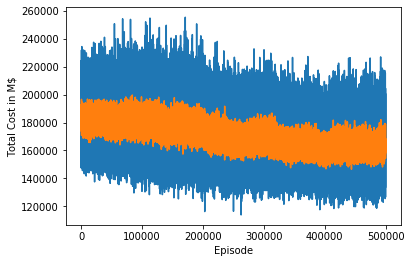

Wall time: 7h 30min 34s


In [28]:
%%time
GAMMA = 0.99
a_g= 0.9; ## Government's cooperation index
a_r= 0.9; ## Residents' cooperation index
a=1; ## SLR scenarios; a=0,1, and 2, respectively for intermediate low, intermediate, and high sea level rise projections. 

s_norm=400,# normalozing s
l_norm=[580, 1190,2590];# normalozing s
scene= ['low','inter','high']
years = 100
max_episodes = 500000
hidden_size = 12

actor_critic = ActorCritic(hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=3e-4)

all_rewards = []
entropy_term = 0
    
for episode in range(max_episodes):
	log_probs = []; # log probabilities of action
	values = []
	rewards = []


	l= np.zeros(101);
	s= np.zeros(101);
	l[0]=100; # initial relative sea level
	s[0]=50; # initial infrastructure state  
	r=0; # sea level rise each year
	q= np.zeros(101);  # yearly residents' decision score          
	sig= np.zeros(101);# yearly sigmoid input for residents' decision           
	res= np.zeros(101); # yearly residents' binary decision 
	x= np.zeros(100); #  yearly govenment's decision         
	z= np.zeros(100); # yearly cost from nature
	state= np.zeros((1,2));
	next_state= np.zeros((1,2));
	for y in range(years):
		state[0,0]= (l[y]-l[0])/l_norm[a];             
		state[0,1]= (s[y]-s[0])/s_norm;             

		value, policy_dist = actor_critic.forward(state)
		value = value.detach().numpy()[0,0] # converts tensor to array
		dist = policy_dist.detach().numpy() # converts tensor to array

		action =np.random.choice(5, p=np.squeeze(dist)) # random.randrange(5)
		x[y]= action;
		z[y]=genpareto.rvs(k, loc=theta, scale=eta* np.power(l[y],power_l)/np.power(s[y],power_s)); # genpareto, shape,k=-0.1,location,theta=0; scale,sigma         
            
		log_prob = torch.log(policy_dist.squeeze(0)[action])
		entropy = -np.sum(np.mean(dist) * np.log(dist))
		q[y+1]=a_r*(q[y]+ action/4 * z[y]); ## dividing the action by 4 because action can be o~3
		sig[y+1]= 1/(1 + np.exp(-(q[y+1]-5)));
		res[y+1]= np.random.binomial(1, sig[y+1]);  

		r= np.random.gamma(A[a,y],B);                                         
		l[y+1]= l[y]+r;                
		s[y+1]= s[y]+action; 
		next_state[0,0]= (l[y+1]-l[0])/l_norm[a]; #  As the growth rate of shape parameter is fixed for any scenario,so {A[a,y]/2+A[a,6]/2-A[a,5]/2} simply means expected sea level rise for next year            
		next_state[0,1]= (s[y+1]-s[0])/s_norm;  
		reward=alpha*x[y]-beta*res[y]+z[y]; 
		rewards.append(reward)  

		values.append(value)
		log_probs.append(log_prob)
		entropy_term += entropy
		state = next_state
            
		if  y == years-1:
			Qval, transition = actor_critic.forward(next_state)
			Qval = Qval.detach().numpy()[0,0]
			all_rewards.append(np.sum(rewards))


			if episode % 10000== 0:                    
				sys.stdout.write("episode: {}, Total Cost in M$: {},val: {}\n"
                                 .format(episode, np.sum(rewards), value))
			break
        
        # compute Q values
	Qvals = np.zeros(years)
	for t in reversed(range(years)):
		Qval = -rewards[t] + GAMMA * Qval
		Qvals[t] = Qval
  
        #update actor critic
	values = torch.FloatTensor(values)
	Qvals = torch.FloatTensor(Qvals)
	log_probs = torch.stack(log_probs)
        
	advantage = Qvals - values
	actor_loss = (-log_probs * advantage).mean()
	critic_loss = 0.5 * advantage.pow(2).mean()
	ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

	ac_optimizer.zero_grad() #Sets gradients of all model parameters to zero, needs to be done before "ac_loss.backward()"
	ac_loss.backward()
	ac_optimizer.step()

    # Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in M$')
plt.show()

episode: 0, Total Cost in M$: 145744.32819501872,val: -0.012086756527423859
episode: 10000, Total Cost in M$: 164595.34696887893,val: 0.006713762879371643
episode: 20000, Total Cost in M$: 161795.99308520704,val: 0.011619716882705688
episode: 30000, Total Cost in M$: 142308.9104201849,val: 0.017062872648239136
episode: 40000, Total Cost in M$: 132909.73747655892,val: 0.01674748957157135
episode: 50000, Total Cost in M$: 142510.2306901545,val: 0.02065812051296234
episode: 60000, Total Cost in M$: 124725.92022057541,val: 0.01774933934211731
episode: 70000, Total Cost in M$: 139163.7760644242,val: 0.01748688519001007
episode: 80000, Total Cost in M$: 133409.55783448328,val: 0.022394582629203796
episode: 90000, Total Cost in M$: 143353.0456767233,val: 0.021145373582839966
episode: 100000, Total Cost in M$: 144113.99246133395,val: 0.026521936058998108
episode: 110000, Total Cost in M$: 131767.22697669067,val: 0.022908642888069153
episode: 120000, Total Cost in M$: 135737.86530082888,val: 0.

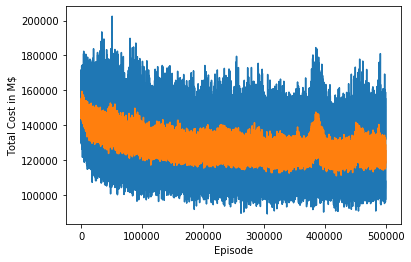

Wall time: 7h 32min 53s


In [38]:
%%time
GAMMA = 0.99
a_g= 0.9; ## Government's cooperation index
a_r= 0.9; ## Residents' cooperation index
a=0; ## SLR scenarios; a=0,1, and 2, respectively for intermediate low, intermediate, and high sea level rise projections. 

s_norm=400,# normalozing s
l_norm=[580, 1190,2590];# normalozing s
scene= ['low','inter','high']
years = 100
max_episodes = 500000
hidden_size = 12

actor_critic = ActorCritic(hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=3e-4)

all_rewards = []
entropy_term = 0
    
for episode in range(max_episodes):
	log_probs = []; # log probabilities of action
	values = []
	rewards = []


	l= np.zeros(101);
	s= np.zeros(101);
	l[0]=100; # initial relative sea level
	s[0]=50; # initial infrastructure state  
	r=0; # sea level rise each year
	q= np.zeros(101);  # yearly residents' decision score          
	sig= np.zeros(101);# yearly sigmoid input for residents' decision           
	res= np.zeros(101); # yearly residents' binary decision 
	x= np.zeros(100); #  yearly govenment's decision         
	z= np.zeros(100); # yearly cost from nature
	state= np.zeros((1,2));
	next_state= np.zeros((1,2));
	for y in range(years):
		state[0,0]= (l[y]-l[0])/l_norm[a];             
		state[0,1]= (s[y]-s[0])/s_norm;             

		value, policy_dist = actor_critic.forward(state)
		value = value.detach().numpy()[0,0] # converts tensor to array
		dist = policy_dist.detach().numpy() # converts tensor to array

		action =np.random.choice(5, p=np.squeeze(dist)) # random.randrange(5)
		x[y]= action;
		z[y]=genpareto.rvs(k, loc=theta, scale=eta* np.power(l[y],power_l)/np.power(s[y],power_s)); # genpareto, shape,k=-0.1,location,theta=0; scale,sigma         
            
		log_prob = torch.log(policy_dist.squeeze(0)[action])
		entropy = -np.sum(np.mean(dist) * np.log(dist))
		q[y+1]=a_r*(q[y]+ action/4 * z[y]); ## dividing the action by 4 because action can be o~3
		sig[y+1]= 1/(1 + np.exp(-(q[y+1]-5)));
		res[y+1]= np.random.binomial(1, sig[y+1]);  

		r= np.random.gamma(A[a,y],B);                                         
		l[y+1]= l[y]+r;                
		s[y+1]= s[y]+action; 
		next_state[0,0]= (l[y+1]-l[0])/l_norm[a]; #  As the growth rate of shape parameter is fixed for any scenario,so {A[a,y]/2+A[a,6]/2-A[a,5]/2} simply means expected sea level rise for next year            
		next_state[0,1]= (s[y+1]-s[0])/s_norm;  
		reward=alpha*x[y]-beta*res[y]+z[y]; 
		rewards.append(reward)  

		values.append(value)
		log_probs.append(log_prob)
		entropy_term += entropy
		state = next_state
            
		if  y == years-1:
			Qval, transition = actor_critic.forward(next_state)
			Qval = Qval.detach().numpy()[0,0]
			all_rewards.append(np.sum(rewards))


			if episode % 10000== 0:                    
				sys.stdout.write("episode: {}, Total Cost in M$: {},val: {}\n"
                                 .format(episode, np.sum(rewards), value))
			break
        
        # compute Q values
	Qvals = np.zeros(years)
	for t in reversed(range(years)):
		Qval = -rewards[t] + GAMMA * Qval
		Qvals[t] = Qval
  
        #update actor critic
	values = torch.FloatTensor(values)
	Qvals = torch.FloatTensor(Qvals)
	log_probs = torch.stack(log_probs)
        
	advantage = Qvals - values
	actor_loss = (-log_probs * advantage).mean()
	critic_loss = 0.5 * advantage.pow(2).mean()
	ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

	ac_optimizer.zero_grad() #Sets gradients of all model parameters to zero, needs to be done before "ac_loss.backward()"
	ac_loss.backward()
	ac_optimizer.step()

    # Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in M$')
plt.show()